In [234]:
import secrets
import pandas as pd
import numpy as np
import seaborn as sns

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [235]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [236]:
import model.basic_model as basic_model
import model.agents as agents
from model.stochastic_processes import (
    create_stochastic_avail_price_process,
    plot_price,
)
from model.agents_class import Stake

In [237]:
import os
import sys
print("Current Working Directory:", os.getcwd())
print("Python Path:", sys.path)


Current Working Directory: /Users/wenxuan/Desktop/polygon/cadCAD/Token-Redesign/avail_fusion_sim
Python Path: ['/Users/wenxuan/Desktop/polygon/cadCAD/Token-Redesign/avail_fusion_sim', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python38.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/lib-dynload', '', '/Users/wenxuan/Desktop/polygon/cadCAD/Token-Redesign/venv/lib/python3.8/site-packages']


In [238]:
# types
Run = int
Timestep = int

# Price Traj Generation

<class 'float'>


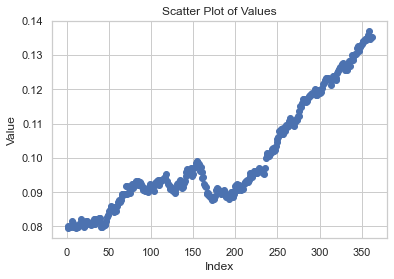

0.07943746846529401


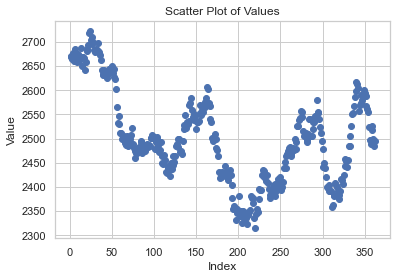

2314.2037527548864


In [239]:
avl_price_samples = create_stochastic_avail_price_process(price_traj_type = 'convex',minimum_avl_price=0.05, target_avg=0.1, maximum_avl_price=1.0,)
plot_price(avl_price_samples) 
print(min(avl_price_samples))

eth_price_samples = create_stochastic_avail_price_process(price_traj_type = 'concave', minimum_avl_price=1500,target_avg=2500, maximum_avl_price=3000)
plot_price(eth_price_samples) 
print(min(eth_price_samples))

# Setup

In [240]:
constants = {
}

# Simulation

In [241]:
const_multiplier = 1e3
AVL_initial_weights = 0.7
AVL_initial_price = avl_price_samples[0]
ETH_initial_price = eth_price_samples[0]
print(AVL_initial_price)

0.07943746846529401


In [242]:
init_agent_eth_alloc = [0.75, 0.43, 1.0]
init_agent_avl_alloc = [1-i for i in init_agent_eth_alloc]
agents_composition = [0.695,0.305,0.0] # sum = 1

In [243]:
init_AVL_price = AVL_initial_price
init_fdv = 10000000000 * init_AVL_price
init_inflation_rate = 4
init_rewards_allocation = 20
init_target_avg_yield = 5
init_total_inflation_rewards = init_fdv * init_inflation_rate /100
init_total_annual_rewards_fusion = init_total_inflation_rewards * init_rewards_allocation / 100


init_target_total_security = init_total_annual_rewards_fusion * 100 / init_target_avg_yield

print(init_target_total_security)

127099949.5444704


In [244]:
init_AVL_security_pct = [ i*j for i,j in zip(init_agent_avl_alloc, agents_composition)]
init_ETH_security_pct = [ i*j for i,j in zip(init_agent_eth_alloc, agents_composition)]

print(init_AVL_security_pct, init_ETH_security_pct)

init_total_AVL_security_pct = sum(init_AVL_security_pct)
init_total_ETH_security_pct = sum(init_ETH_security_pct)

print([i/init_total_AVL_security_pct for i in init_AVL_security_pct])
print([i/init_total_ETH_security_pct for i in init_ETH_security_pct])

agents_avl_balance = [init_target_total_security * pct / AVL_initial_price for pct in init_AVL_security_pct]
agents_eth_balance = [init_target_total_security * pct / ETH_initial_price for pct in init_ETH_security_pct]

print(agents_avl_balance)
print(agents_eth_balance)

[0.17375, 0.17385, 0.0] [0.52125, 0.13115, 0.0]
[0.49985615650172605, 0.5001438434982739, 0.0]
[0.7989730226854691, 0.20102697731453095, 0.0]
[277999999.99999994, 278159999.99999994, 0.0]
[24815.54437827465, 6243.757592730399, 0.0]


In [245]:
df = pd.DataFrame({
    'Agent ETH Allocation %': init_agent_eth_alloc,
    'Agent AVL Allocation %': init_agent_avl_alloc
})
df['Agent ETH Allocation %'] = df['Agent ETH Allocation %'].apply(lambda x: f"{x:.2%}")
df['Agent AVL Allocation %'] = df['Agent AVL Allocation %'].apply(lambda x: f"{x:.2%}")
print(df)


avl_normalized = [i / sum(init_AVL_security_pct) for i in init_AVL_security_pct]
eth_normalized = [i / sum(init_ETH_security_pct) for i in init_ETH_security_pct]

df = pd.DataFrame({
    'AVL Security %': avl_normalized,
    'ETH Security %': eth_normalized
})
df['AVL Security %'] = df['AVL Security %'].apply(lambda x: f"{x:.2%}")
df['ETH Security %'] = df['ETH Security %'].apply(lambda x: f"{x:.2%}")
print(df)


df = pd.DataFrame({
    'User Total Proportion': agents_composition
})
df['User Total Proportion'] = df['User Total Proportion'].apply(lambda x: f"{x:.2%}")
print(df)


df = pd.DataFrame({
    'Total Security %': [init_total_AVL_security_pct*100, init_total_ETH_security_pct*100]
}, index=['AVL', 'ETH'])
df['Total Security %'] = df['Total Security %'].apply(lambda x: f"{x:.0f}%")
print(df)

  Agent ETH Allocation % Agent AVL Allocation %
0                 75.00%                 25.00%
1                 43.00%                 57.00%
2                100.00%                  0.00%
  AVL Security % ETH Security %
0         49.99%         79.90%
1         50.01%         20.10%
2          0.00%          0.00%
  User Total Proportion
0                69.50%
1                30.50%
2                 0.00%
    Total Security %
AVL              35%
ETH              65%


In [246]:
@dataclass
class FusionParams:
    # TODO: Set a AVL amount budget cap
    AVL_upper_budget_cap = 1.12e8
    ETH_upper_budget_cap = 2.08e8

    AVL_initial_weights: List[float] = default([AVL_initial_weights])

    avl_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: avl_price_samples[timestep]]
    )
    eth_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: eth_price_samples[timestep]]
    )

    # inlation % on AVL
    inflation_rate: List[float] = default([init_inflation_rate])

    # % of Rewards Allocated to Fusion
    rewards_allocation: List[float] = default([init_rewards_allocation])


    # Reward Allocation to Pools
    ETH_reward_pct: List[float] = default([40])
    AVL_reward_pct: List[float] = default([60])


    # % of Fusion Security Standard met by ETH Stake
    # TODO: implementation
    ETH_upper_security_pct: List[float] = default([35])
    AVL_upper_security_pct: List[float] = default([65])



    # Agents
    ETH_agent_allocation: List[List[float]] = default([
        init_agent_eth_alloc
    ])
    AVL_agent_allocation: List[List[float]] = default([
        init_agent_avl_alloc
    ])
    Agents_composition: List[List[float]] = default([
        agents_composition
    ])

    agents_avl_balance: List[List[float]] = default([
        agents_avl_balance
    ])

    agents_eth_balance: List[List[float]] = default([
        agents_eth_balance
    ])

parameters = FusionParams().__dict__

In [247]:
psub = [
    {
        "policies": {
             },
        "variables": {
            "timestep": basic_model.update_timestep,
            "avl_price": basic_model.update_avl_price,
            "eth_price": basic_model.update_eth_price,
        }
    },
    {
        "policies": {
            "action":basic_model.calc_rewards
             },
        "variables": {
            "total_annual_rewards": basic_model.update_total_annual_rewards,
            "total_annual_rewards_fusion": basic_model.update_total_annual_rewards_fusion,
            "total_fdv": basic_model.update_total_fdv,
        }
    }, 
    {
        "policies": {
            "action": basic_model.calc_security_shares
            },
            "variables": {
                "AVL_security_pct": basic_model.update_AVL_pct,
                "ETH_security_pct": basic_model.update_ETH_pct,
                "total_security": basic_model.update_total_security,
                "ETH_stake": basic_model.update_ETH_stake,
                "AVL_stake": basic_model.update_AVL_stake,
            }
    },
    {
        "policies": {
            "action": agents.calc_rewards_allocation
            },
            "variables": {
                "AVL_stake": agents.update_AVL_stake,
                "ETH_stake": agents.update_ETH_stake,
            }
    },
    {
        "policies": {
            "action": agents.calc_yields
            },
            "variables": {
                "yield_pcts": agents.update_yields,
                "avg_yield": agents.update_avg_yield,
            }
    },
]

initial_conditions = {
    "timestep": 0,
    "avl_price": AVL_initial_price,
    "eth_price": ETH_initial_price, 
    "AVL_security_pct": sum(init_AVL_security_pct) * 100,
    "ETH_security_pct": sum(init_ETH_security_pct) * 100,
    "total_security": init_target_total_security,
    # "target_total_security": init_target_total_security,
    "total_fdv": init_fdv,
    "total_annual_rewards": init_total_inflation_rewards,
    "total_annual_rewards_fusion": init_total_annual_rewards_fusion,
    "avg_yield": 5.0,
    "ETH_stake": Stake(ETH_initial_price, agents_eth_balance,0,0),
    "AVL_stake": Stake(AVL_initial_price, agents_avl_balance,0,0),
    "yield_pcts": [0,0,0],
    "avg_yield": 0.0,
}


params = parameters

model = Model(
        initial_state=initial_conditions,
        state_update_blocks=psub,
        params=params,
    )

In [248]:
simulation = Simulation(model=model, timesteps=300, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
results = experiment.run()
df = pd.DataFrame(results)

44179942.46165791
82920007.08281249
44587864.65882012
82952423.00348806
44432685.41800299
82739356.95215091
44437799.68290087
83145595.10755922
44512808.71192859
82629353.1856455
45350794.27821283
83377138.98823604
45037798.18185161
83089248.86413744
44340152.84341471
82959111.44790784
44647991.48988728
82587950.61716774
44652891.23317583
83084673.68064821
44248227.0533519
82649574.144609
44342158.57948485
82904148.59612164
44463424.289892584
83451300.19014175
44740807.314037085
82872604.026936
44721744.81309272
82332746.56671435
45131194.055011526
82884532.40696254
45673443.75101423
82813493.6029041
45079242.22725497
82065912.85129797
45282478.34219089
82576686.2192324
44582887.30138695
83249775.7598055
44462663.58195196
83414260.21007366
44749979.66458647
83674358.3382734
45405399.27267295
84418862.43280917
45313154.38957911
84582050.04587056
45043919.4034899
84015494.4807324
44829685.197437406
83722855.46485445
45116012.72827351
84208076.6296922
45042548.65900431
83842598.93059744
4

/Users/wenxuan/Desktop/polygon/cadCAD/Token-Redesign/avail_fusion_sim/model/agents.py:46: RuntimeWarning:

invalid value encountered in double_scalars




74409869.63423783
53192628.39886968
74318418.67294572
53413219.92356408
74343096.73692809
53963770.44620735
75279741.49328105
53899745.73471532
75616313.71812972
53462554.89049439
75580210.69664425
53454946.07818456
75158629.15119386
53675401.609050184
75256847.76845726
53167034.674506865
74911322.9372007
53038134.31142075
75314092.34107152
53903704.28148708
74819061.02578531
55682584.61441602
74439790.43471019
56140029.83733774
73821716.27751137
56379954.702935584
74022370.457672
56029170.37993754
74050434.16552106
55883746.03524071
74228719.90984926
56226693.125182435
74475273.45453212
56612682.1660741
74656425.7349494
56505127.687785506
74700586.3504697
57100919.93321895
73991351.4601761
57235688.83251712
74277140.90514638
56818859.98842133
74392732.63948539
56950338.86254911
75040468.7799181
57619774.16932851
74794849.32740535
58200624.15707271
75212723.99303892
58722263.837819636
74576809.93887213
58962004.93959482
74370243.22938338
59918893.73490691
74535959.45701775
60069969.12

In [249]:
df

,timestep,avl_price,eth_price,AVL_security_pct,ETH_security_pct,total_security,total_fdv,total_annual_rewards,total_annual_rewards_fusion,avg_yield,ETH_stake,AVL_stake,yield_pcts,simulation,subset,run,substep
0,0,0.079437,2669.73183,34.760000,65.240000,1.270999e+08,7.943747e+08,3.177499e+07,6.354997e+06,0.000000,"Stake(initial_price=2669.731829782306, agents_...","Stake(initial_price=0.07943746846529401, agent...","[0, 0, 0]",0,0,1,0
1,1,0.079437,2669.73183,34.760000,65.240000,1.270999e+08,7.943747e+08,3.177499e+07,6.354997e+06,0.000000,"Stake(initial_price=2669.731829782306, agents_...","Stake(initial_price=0.07943746846529401, agent...","[0, 0, 0]",0,0,1,1
2,1,0.079437,2669.73183,34.760000,65.240000,1.270999e+08,7.943747e+08,3.177499e+07,6.354997e+06,0.000000,"Stake(initial_price=2669.731829782306, agents_...","Stake(initial_price=0.07943746846529401, agent...","[0, 0, 0]",0,0,1,2
3,1,0.079437,2669.73183,34.760000,65.240000,1.270999e+08,7.943747e+08,3.177499e+07,6.354997e+06,0.000000,"Stake(initial_price=2669.731829782306, agents_...","Stake(initial_price=0.07943746846529401, agent...","[0, 0, 0]",0,0,1,3
4,1,0.079437,2669.73183,34.760000,65.240000,1.270999e+08,7.943747e+08,3.177499e+07,6.354997e+06,0.000000,"Stake(initial_price=2669.731829782306, agents_...","Stake(initial_price=0.07943746846529401, agent...","[0, 0, 0]",0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,300,0.119654,2440.34505,46.206746,53.793254,1.440362e+08,1.196678e+09,4.786712e+07,9.573424e+06,6.646540,"Stake(initial_price=2494.6394406235745, agents...","Stake(initial_price=0.11966779488106354, agent...","[6.231529556342562, 7.45488595562348, nan]",0,0,1,1
1497,300,0.119654,2440.34505,46.206746,53.793254,1.440362e+08,1.196541e+09,4.786164e+07,9.572328e+06,6.646540,"Stake(initial_price=2494.6394406235745, agents...","Stake(initial_price=0.11966779488106354, agent...","[6.231529556342562, 7.45488595562348, nan]",0,0,1,2
1498,300,0.119654,2440.34505,46.751285,53.248715,1.423422e+08,1.196541e+09,4.786164e+07,9.572328e+06,6.646540,"Stake(initial_price=2440.345049695927, agents_...","Stake(initial_price=0.11965410507327533, agent...","[6.231529556342562, 7.45488595562348, nan]",0,0,1,3
1499,300,0.119654,2440.34505,46.751285,53.248715,1.423422e+08,1.196541e+09,4.786164e+07,9.572328e+06,6.646540,"Stake(initial_price=2440.345049695927, agents_...","Stake(initial_price=0.11965410507327533, agent...","[6.231529556342562, 7.45488595562348, nan]",0,0,1,4


In [250]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
    0: "downside",
}
)

In [251]:
visualizations.plot_security_pct(
    df
)

In [252]:
visualizations.plot_avg_overall_yield(
    df
)

In [253]:
visualizations.plot_yield_pct(
    df, init_agent_eth_alloc
)